## LSTM for lag

- p5a: Copied from https://cmsdk.com/python/lstm--learn-a-simple-lag-in-the-data.html
- p5b: my fixes
- p5c: Use LSTM-based AE (i.e. no output, just unsupervised dimensionality reduction)
- p5d: LSTM-based AE made more efficient?
- p5e: LSTM-based AE on GPU + middle encoding layer
- p5f: remove dropout and use optimizer=nadam
- p5g: LSTM-60-20-1-20-60, LSTM-60-20-2-20-60, ...

Other references
  - some LSTM AE code in Keras [issue 1401](https://github.com/fchollet/keras/issues/1401#issuecomment-309443122)
    - http://colah.github.io/posts/2015-08-Understanding-LSTMs/
  - https://github.com/fchollet/keras/issues/5138#issuecomment-274893934

### below model results summary

with enc_dim=1 (using Dense layer):
-    loss reaches 0.70 in  50 epochs and slows down dramatically, prediction does not display lags

with enc_dim=None:
-    loss reaches 0.01 in 150 epochs, prediction displays lags

with enc_dim=10 (using Dense layer):
- Epoch 65/200: 6s - loss: 0.1557 - val_loss: 0.1536
  - predictions do not display lags
  
with enc_dim=10 (using LSTM layer):
- Epoch 107/200 - loss: 0.0772 - val_loss: 0.0786
  - 1st 2 predicted features display lag, 3rd feature still negligible
- Epoch 107+200/200 - loss: 0.0714 - val_loss: 0.0711
  - 1st 2 predicted features display lag, 3rd feature still negligible
  
add dropout
- Epoch 67/200 - loss: 0.1838 - val_loss: 0.1620
  - no visible correlations

Tried and failed to make it more efficient
- with enc_dim != None,
  - try to pretrain without the intermediate stacked LSTM
  - then train with it
  - ref: https://stackoverflow.com/a/41661229/4126114
- cannot instantiate network without encoding layer, train, instantiate with encoding, copy weights, train
  - because the input to the output layer is different in these 2 cases
  - will try to just freeze the encoding layer with `rnn_model.trainable = False` and train, then set to True, and train
  - will also need to see if this is really more efficient  

Run on GPU
- super fast
- enc_dim = 10, data length = 100e3
  - Epoch 50+27/300   8s - loss: 0.2472 - val_loss: 0.2166
    - reconstructed features 1 & 2 display lag, but 3 doesnt and is still small
  - epoch 27+50+50+63    8s - loss: 0.1118 - val_loss: 0.0896
    - features 1 & 2 lag is better, but 3 still not
  - Epoch 27+50+50+63+50/300   8s - loss: 0.0995 - val_loss: 0.0825
    - features 1 & 2 lag is almost perfect, but 3 still negligible

Use nadam and remove dropout
- [nadam](https://keras.io/optimizers/) says something about adam and momentum.
    - note that the [keras docs](https://keras.io/getting-started/sequential-model-guide/) on stacked lstm just use rmsprop
    - "in my experience, adam is better than rmsprop" ([ref](https://github.com/fchollet/keras/issues/1401#issuecomment-169295237))
- Epoch 64/300    8s - loss: 0.0770 - val_loss: 0.0843

LSTM-20 + LSTM-20
- Epoch 40/300     6s - loss: 0.0239 - val_loss: 0.0207
  - features 1 & 2 display lag very well, feature 3 is starting to display lag
- Epoch 24/300     6s - loss: 0.0056 - val_loss: 0.0049

Use `optimizer = Nadam(lr=1, schedule_decay=0.0)`
- is this like increasing gradient step size?

LSTM-20 + LSTM-1 + LSTM-20
- reached 0.73 after 40 epochs
- seems to have plateaud

LSTM-1
- Epoch 41/300    2s - loss: 0.6639 - val_loss: 0.6722
- seems to have plateaud

LSTM-60 + LSTM-1 + LSTM-60
- after 300 epochs, loss = 0.69

LSTM-20 + LSTM-20, optimizer = adam
- Epoch 44/300     6s - loss: 0.0144 - val_loss: 0.0134
- Epoch 75/300     6s - loss: 0.0032 - val_loss: 0.0037
- reconstructed features are very very close to originals (with display of lag)

LSTM-60 + LSTM-20 + LSTM-60, optimizer = adam
- Epoch 39/300    20s - loss: 0.0051 - val_loss: 0.0041
- R2 = 0.997 (reconstructed features show lag)

LSTM-60 + LSTM-20 + LSTM-1 + LSTM-20 + LSTM-60, optimizer = adam
- Epoch 14/300    24s - loss: 0.3688 - val_loss: 0.3734
  - R2 = 0.45
  - some visible lag, but still early to see
- Epoch 14+10/300    24s - loss: 0.2828 - val_loss: 0.2925
  - single encoded feature still not meaningful
- Epoch 14+10+20/300    23s - loss: 0.1952 - val_loss: 0.1926
  - R2 = 0.58
  - more visible lag, but still 3rd feature is negligible
  - single encoded feature starting to look like the single important component
- Epoch 14+10+20+41/300    24s - loss: 0.1209 - val_loss: 0.1116
  - R2 = 0.63
  - first 2 features correlation is visible, last feature yet to see
  - encoded feature yet to become more like single component
- Epoch 14+10+20+41+6/300    24s - loss: 0.1066 - val_loss: 0.1064
- Epoch 14+10+20+41+6+116/300  24s - loss: 0.0670 - val_loss: 0.0691
  - R2 = 0.6
  - first 2 feature correlation visible, 3rd feature negligible
  - encoded feature not trustworthy because in/out not perfectly replicated

LSTM-60 + LSTM-20 + LSTM-2 + LSTM-20 + LSTM-60
- IN PROGRESS

LSTM-60 + LSTM-20 + LSTM-3 + LSTM-20 + LSTM-60
- IN PROGRESS

LSTM-60 + LSTM-20 + LSTM-4 + LSTM-20 + LSTM-60
- IN PROGRESS

LSTM-60-20-10-5-1-5-10-20-60
- IN PROGRESS

In [1]:
# import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras
def strided_app(a, L, S ):  #To get X in the right format expected by Keras
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

import utils
import utils2

Using TensorFlow backend.


model (99998, 3)


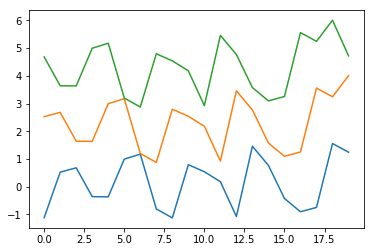

calib (99989, 10, 3)


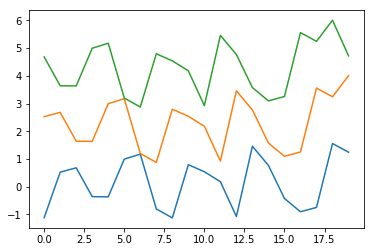

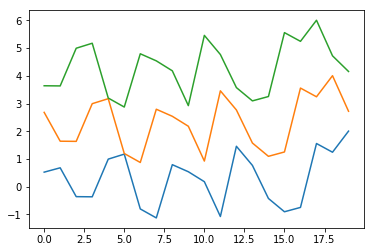

In [2]:
nb_samples = int(100e3) # FIXME # 100e3
X = np.random.randn(nb_samples)
# generate data with 3-lag correlation: X(t-1), X(t), and X(t+1)
timesteps = 3

X_model = strided_app(X, timesteps, 1)
print('model', X_model.shape)
utils.myPlot(X_model[:20],2)

# The first striding above was done in order to generate the input data with a built-in lag relationship
# Now need to stride again because we need to pretend that we do not know that the input has this correlation
# Without this re-striding, it's like telling the model to get y=X
look_back = 10
X_calib      = utils2._load_data_strides(X_model,       n_prev=look_back)
print('calib', X_calib.shape)
utils.myPlot(X_calib[:20,0,:],2) # same as earlier plot
utils.myPlot(X_calib[:20,1,:],2) # lagged version of above plot

In [3]:
# SPLIT train/validation/test
nb_samples_calib = X_calib.shape[0]
nb_train = int(nb_samples_calib * 0.7)
nb_val = int(nb_samples_calib * 0.85)
# strided version
Xc_train = X_calib[: nb_train]
Xc_validation = X_calib[nb_train : nb_val]
Xc_test = X_calib[nb_val:]
# unstrided version
Xm_train = X_model[: nb_train]
Xm_validation = X_model[nb_train : nb_val]
Xm_test = X_model[nb_val:]

print('strided',   Xc_train.shape, Xc_validation.shape, Xc_test.shape)
print('unstrided', Xm_train.shape, Xm_validation.shape, Xm_test.shape)

strided (69992, 10, 3) (14998, 10, 3) (14999, 10, 3)
unstrided (69992, 3) (14998, 3) (15008, 3)


In [4]:
# Note 1: no dropout
# Note 2: add encoded dimension
# Using build_lstm_vanilla with enc_dim doesn't work as the output features cannot be lagged from each other
#    with enc_dim = 1, and no LSTM after enc_dim: until epoch=100, loss: 0.6737 - val_loss: 0.6645
#                                                 until epoch=200, loss: 0.6724 - val_loss: 0.6615
#enc_dim = 1
#model = utils2.build_lstm_vanilla(in_neurons=Xc_train.shape[2], out_neurons=Xm_train.shape[1], lstm_dim=20, enc_dim=enc_dim)

from keras.optimizers import Nadam
lstm_dim = 60 # FIXME 60 20
enc_dim = [20,10,5,1,5,10,20] # FIXME 10 1 None 20
optimizer = 'adam' # FIXME Nadam(lr=1, schedule_decay=0.0) # lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model = utils2.build_lstm_ae(in_neurons=Xc_train.shape[2], lstm_dim=lstm_dim, look_back=look_back, enc_dim=enc_dim, optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 60)          15360     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          6480      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 10)          1240      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 5)           320       
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 1)           28        
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 5)           140       
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 10)          640       
__________

In [5]:
epochs = 300 # FIXME # 100

#weights_path = 'weights.h5'
#early_stopping = EarlyStopping(monitor='val_loss',
#                           patience=100)
#checkpointer = ModelCheckpoint(filepath=weights_path,
#                           verbose=2,
#                           save_best_only=True)
#callbacks = [early_stopping, checkpointer]
history = model.fit(Xc_train,
                    Xc_train, # the TimeDistributed in the model allows me to train again Xc instead of Xm
                    epochs = epochs, # FIXME # 10000,
                    callbacks = [], #callbacks,
                    verbose = 2,
                    # since stateless, make sure this is larger than the look-back=10 and the generated lag=3
                    batch_size = 500, # FIXME # 100
                    validation_data = (Xc_validation,
                                       Xc_validation),
                    shuffle = True)


Train on 69992 samples, validate on 14998 samples
Epoch 1/300
98s - loss: 0.9156 - val_loss: 0.8649
Epoch 2/300
93s - loss: 0.8234 - val_loss: 0.7854
Epoch 3/300
94s - loss: 0.7654 - val_loss: 0.7576
Epoch 4/300
96s - loss: 0.7372 - val_loss: 0.7318
Epoch 5/300
95s - loss: 0.7044 - val_loss: 0.7309
Epoch 6/300
94s - loss: 0.6658 - val_loss: 0.6549
Epoch 7/300
94s - loss: 0.6377 - val_loss: 0.6379
Epoch 8/300
95s - loss: 0.5987 - val_loss: 0.6096
Epoch 9/300
94s - loss: 0.5562 - val_loss: 0.5503
Epoch 10/300
95s - loss: 0.5286 - val_loss: 0.5326
Epoch 11/300
95s - loss: 0.5054 - val_loss: 0.5188
Epoch 12/300
95s - loss: 0.4756 - val_loss: 0.4755
Epoch 13/300
94s - loss: 0.4373 - val_loss: 0.4107
Epoch 14/300
95s - loss: 0.4019 - val_loss: 0.3895
Epoch 15/300
94s - loss: 0.3758 - val_loss: 0.3537
Epoch 16/300
93s - loss: 0.3554 - val_loss: 0.3458
Epoch 17/300
93s - loss: 0.3400 - val_loss: 0.3394
Epoch 18/300
92s - loss: 0.3267 - val_loss: 0.3238
Epoch 19/300
92s - loss: 0.3211 - val_los

92s - loss: 0.0688 - val_loss: 0.0693
Epoch 161/300
91s - loss: 0.0689 - val_loss: 0.0711
Epoch 162/300
92s - loss: 0.0690 - val_loss: 0.0698
Epoch 163/300
92s - loss: 0.0688 - val_loss: 0.0700
Epoch 164/300
91s - loss: 0.0688 - val_loss: 0.0692
Epoch 165/300
91s - loss: 0.0689 - val_loss: 0.0700
Epoch 166/300
92s - loss: 0.0688 - val_loss: 0.0690
Epoch 167/300
92s - loss: 0.0687 - val_loss: 0.0704
Epoch 168/300
92s - loss: 0.0689 - val_loss: 0.0691
Epoch 169/300
91s - loss: 0.0688 - val_loss: 0.0713
Epoch 170/300
92s - loss: 0.0688 - val_loss: 0.0689
Epoch 171/300
91s - loss: 0.0687 - val_loss: 0.0689
Epoch 172/300
91s - loss: 0.0686 - val_loss: 0.0689
Epoch 173/300
91s - loss: 0.0688 - val_loss: 0.0697
Epoch 174/300
92s - loss: 0.0686 - val_loss: 0.0697
Epoch 175/300
92s - loss: 0.0687 - val_loss: 0.0699
Epoch 176/300
92s - loss: 0.0686 - val_loss: 0.0688
Epoch 177/300
92s - loss: 0.0686 - val_loss: 0.0689
Epoch 178/300
91s - loss: 0.0686 - val_loss: 0.0691
Epoch 179/300
91s - loss: 

In [6]:
# history.history['loss']

X (69992, 10, 3) Y (69992, 3) pred (69992, 10, 3)
reshaped pred (69992, 3)


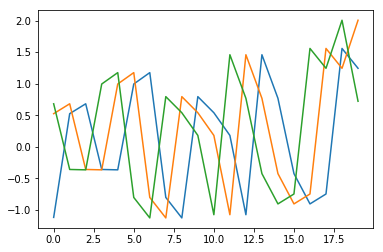

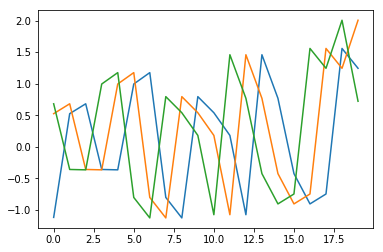

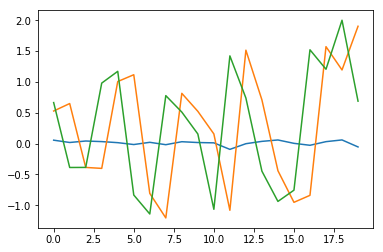

0.667212897369
X (14998, 10, 3) Y (14998, 3) pred (14998, 10, 3)
reshaped pred (14998, 3)


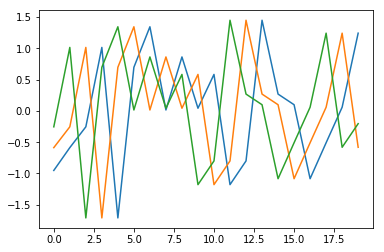

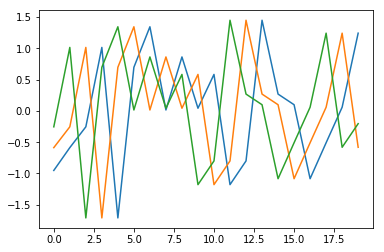

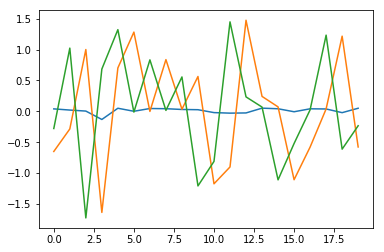

0.666441571972


In [9]:
from matplotlib import pyplot as plt
def myPlot(X):
    plt.plot(X)
    plt.show()

#def R2(X, Y, model):
#    Y_mean = np.mean(Y, axis=0)
#    pred = model.predict(X)
#    res = np.sum(np.square(Y - pred))
#    tot = np.sum(np.square(Y - Y_mean))
#    r2 = 1 - res / tot
#    return r2

def R2(X, Y, model):
    Y_mean = np.mean(Y, axis=0)
    pred = model.predict(X)
    print('X', X.shape, 'Y', Y.shape, 'pred', pred.shape)
    #pred = pred.reshape(Y.shape[0])
    pred = pred[:,0,:]
    print('reshaped pred', pred.shape)
    res = np.sum(np.square(Y - pred))
    tot = np.sum(np.square(Y - Y_mean))
    r2 = 1 - res / tot
    myPlot(X[:20,0])
    myPlot(Y[:20])
    myPlot(pred[:20])
    return r2

#model.load_weights(weights_path)
print(R2(Xc_train,      Xm_train,      model))
print(R2(Xc_validation, Xm_validation, model))
# some dimensionality problems
# print(R2(Xc_test,       Xm_test,       model))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, None, 3)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          15360     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          6480      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 10)          1240      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 5)           320       
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 1)           28        
Total params: 23,428
Trainable params: 23,428
Non-trainable params: 0
_________________________________________________________________
(14999

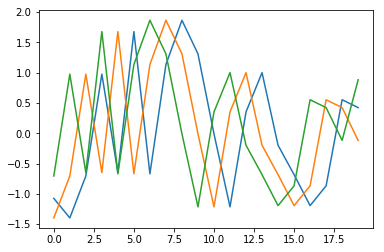

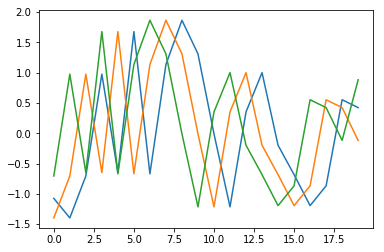

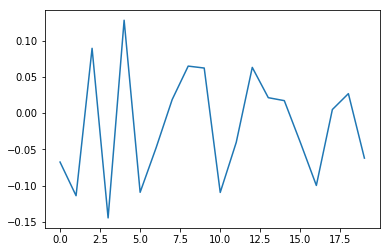

In [10]:
# check encoded signal: expect detection of 1 of the lagged features in X
from keras.models import Model
lstm_enc = Model(inputs=model.input, outputs=model.layers[4].output)
lstm_enc.compile(loss="mean_squared_error", optimizer="rmsprop")
lstm_enc.summary()

X_enc = lstm_enc.predict(Xc_test)
print(Xc_test.shape, Xm_test.shape, X_enc.shape)
utils.myPlot(Xc_test[:20,0,:],0)
utils.myPlot(Xm_test[:20],0)
utils.myPlot(X_enc[:20,0],0)